## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import glob
import matplotlib as plt
from collections import OrderedDict
import random

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from sklearn.model_selection import train_test_split


from Utils import *

## Subject 1 Data and Events Loading 

In [2]:
loaded_data,load_labels = load_data(subject_count=8)

Subject 1:   0%|          | 0/8 [00:00<?, ?it/s]

Subject 8: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


In [3]:
def process_load_labels(load_labels,number_of_subj):
    """
    Process a list of dataframes(labels) by filtering rows where the sum of values is less than or equal to 1.
    This function removes data points where there are more than one class present.

    Args:
        load_labels (list of DataFrame): A list of DataFrames to be processed.

    Returns:
        list of DataFrame: The processed list of DataFrames.
    """
    processed_load_labels = []
    
    for i in range(number_of_subj):
        df_copy = load_labels[i].copy()
        df_copy['sum'] = df_copy.sum(axis=1)
        df_copy = df_copy[df_copy['sum'] <= 1]
        df_copy = df_copy.drop(columns=['sum'])
        processed_load_labels.append(df_copy)
    
    return processed_load_labels
# for i in range(len(load_labels)):
#     df_copy = load_labels[i].copy()
#     df_copy['sum'] = df_copy.sum(axis=1)
#     df_copy = df_copy[df_copy['sum'] <= 1]
#     df_copy = df_copy.drop(columns=['sum'])
#     load_labels[i] = df_copy
processed_labels = process_load_labels(load_labels,6)

In [4]:
len(load_labels)

8

In [42]:
beg_end = []
for data in processed_labels[:6]:
    val = start_end_data_finder(data)
    beg_end.append(val)

In [43]:
def process_start_end(start_end:list, threshold:int):
    """
    Process the start_end data by applying a threshold to the values.

    Args:
        start_end (list): A list of dictionaries containing start and end values.
        threshold (int): The threshold value to compare against. Values greater
            than the threshold will be adjusted.

    Returns:
        list: The processed start_end data with adjusted values.
    """
    for i in range(len(start_end)):
        for key, value in start_end[i].items():
            new_value = []
            found_pair = False
            for idx in range(0, len(value), 2):
                if idx + 1 < len(value):
                    a = value[idx + 1] - value[idx]
                    if a > threshold:
                        x = value[idx]
                        y = x + threshold
                        new_value.extend([x, y])
                        found_pair = True
                    elif a == threshold:
                        new_value.extend([value[idx], value[idx + 1]])
                    elif a < threshold:
                        # If the difference is less than the threshold, remove these values
                        value[idx] = None
                        value[idx + 1] = None

            # Filter out None values (values less than the threshold) from the list
            new_value = [v for v in new_value if v is not None]
            start_end[i][key] = new_value
    
    return start_end


# for i in range(6):
#     for key, value in start_end[i].items():
#         new_value = []
#         found_pair = False
#         for idx in range(0, len(value), 2):
#             if idx + 1 < len(value):
#                 a = value[idx + 1] - value[idx]
#                 if a > 50 :
#                     x = value[idx]
#                     y = x + 50
#                     new_value.extend([x, y])
#                     found_pair = True
#                 elif a == 50:
#                     new_value.extend([value[idx], value[idx + 1]])
#                 elif a < 50:
#                     # If the difference is less than 50, remove these values
#                     value[idx] = None
#                     value[idx + 1] = None

#         # Filter out None values (values less than 50) from the list
#         new_value = [v for v in new_value if v is not None]
#         start_end[i][key] = new_value

start_end_data = process_start_end(start_end = beg_end, threshold=20)


In [44]:
all_extracted_data = []
for i in range(len(start_end_data)):
    extracted_data = data_extractor(start_end_data[i],loaded_data[i])
    all_extracted_data.append(extracted_data)

In [53]:
class_data = {}
combined_dict = {}
for class_idx in range(6):
    class_data[class_idx] = []

for id, sublist in enumerate(all_extracted_data):
    for idx, secondary_list in enumerate(sublist):
        class_data[idx].append(len(secondary_list))

for class_idx, lengths in class_data.items():
    total_length = sum(lengths)
    combined_dict[f"{class_idx}"] = total_length
    print(f"Class {class_idx}: Data points = {total_length}")


Class 0: Data points = 1560
Class 1: Data points = 1367
Class 2: Data points = 806
Class 3: Data points = 1548
Class 4: Data points = 1372
Class 5: Data points = 1372


In [111]:
# Initialize a list to store combined data for each class
combined_data = [[] for _ in range(6)]  # Assuming you have 6 classes

# Iterate through subjects and classes
for i in range(6):  # 6 subjects
    for j in range(6):  # 6 classes
        # Extend the data for the current class to the combined_data
        combined_data[j].extend(all_extracted_data[i][j])

# Now, combined_data contains 6 lists, each for classes of all subjects combined


In [82]:
min_length = min(combined_dict.values(), key=lambda x: int(x))
min_length


806

In [83]:
no_events_data_extracted = []
for idx, subj_data in enumerate(loaded_data):
    no_event = data_extractor_noevent(subj_data, load_labels[idx], min_length)
    no_events_data_extracted.append(no_event)


In [84]:
class_labels = np.ones(min_length*6)

for i in range(6):
    class_labels[i*min_length:(i+1)*min_length] = class_labels[i*min_length:(i+1)*min_length] *(i)

noevent_label = np.ones(min_length)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))

In [112]:


# Initialize combined_data as a list of lists (for demonstration purposes)

# Shuffle and concatenate data from combined_data
selected_data = []
for class_data in combined_data:
    # Append the first `min_length` data points to the selected_data list
    selected_data.extend(class_data[:min_length])

# Shuffle and concatenate data from no_events_data_extracted
for arr in no_events_data_extracted:
    # Check if the current array has enough data to select min_length/6 points
    if len(arr) >= min_length // 6:
        # Shuffle the data points within the array (optional)
        random.shuffle(arr)
    
        # Append the first `min_length/6` data points to the selected_data list
        selected_data.extend(arr[:min_length // 6])


In [113]:
len(selected_data)

728

In [114]:
len(selected_data[5]),len(selected_data[3])

(21, 21)

In [115]:
len(selected_data),type(selected_data),len(labels),type(labels)

(728, list, 5639, numpy.ndarray)

In [40]:
selected_data = np.array(selected_data)
selected_data = np.reshape(np.array(selected_data),(selected_data.shape[0],selected_data.shape[1]*selected_data.shape[2]))

In [41]:
print("selected_data shape:", selected_data.shape)
print("labels shape:", labels.shape)
print("selected_data data type:", selected_data.dtype)
print("labels data type:", labels.dtype)

selected_data shape: (7058, 1632)
labels shape: (6738,)
selected_data data type: int64
labels data type: float64


## Data preprocessing

In [18]:
# start_end_data = start_end_data_finder(all_labels)
# data_extracted_occurances = np.reshape(data_extractor(start_end_data,all_data),(6*260,150,32) )

# no_events_data_extracted = data_extractor_noevent(all_data, all_labels,1560)
# final_data = np.empty(1560*150*32)
# final_data = np.concatenate((data_extracted_occurances,no_events_data_extracted))
# final_data = np.reshape(final_data, (3120,150*32))

# class_labels = np.ones(1560)

# for i in range(6):
#     class_labels[i*260:(i+1)*260] = class_labels[i*260:(i+1)*260] *(i)

# noevent_label = np.ones(1560)*(6)

# all_class_labels = np.concatenate((class_labels,noevent_label))


#### Scaling and Shuffling

In [19]:

from sklearn.preprocessing import StandardScaler
all_data_shuffled , all_labels_shuffled = shuffle(selected_data, labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


### Dimentionality reduction

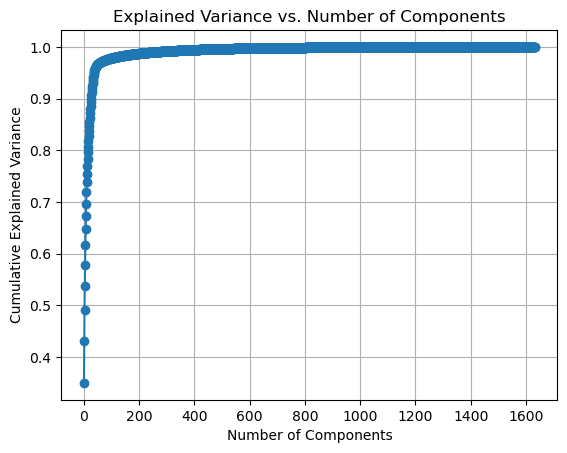

In [20]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [21]:
n_components = 100
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

Accuracy: 0.9681008902077152


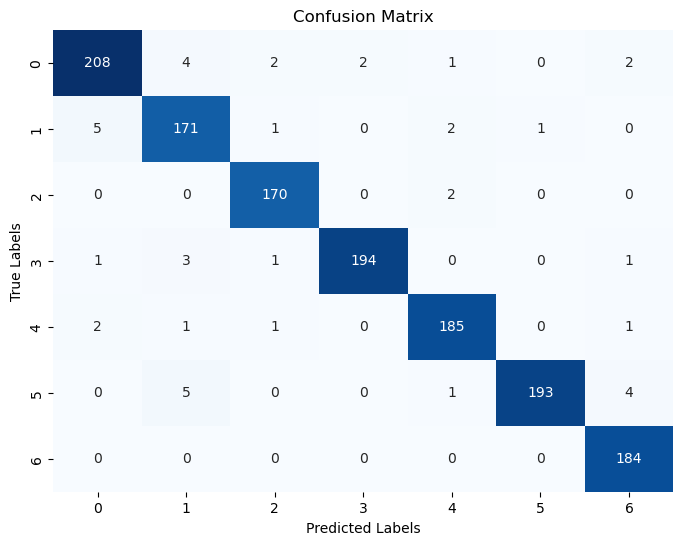

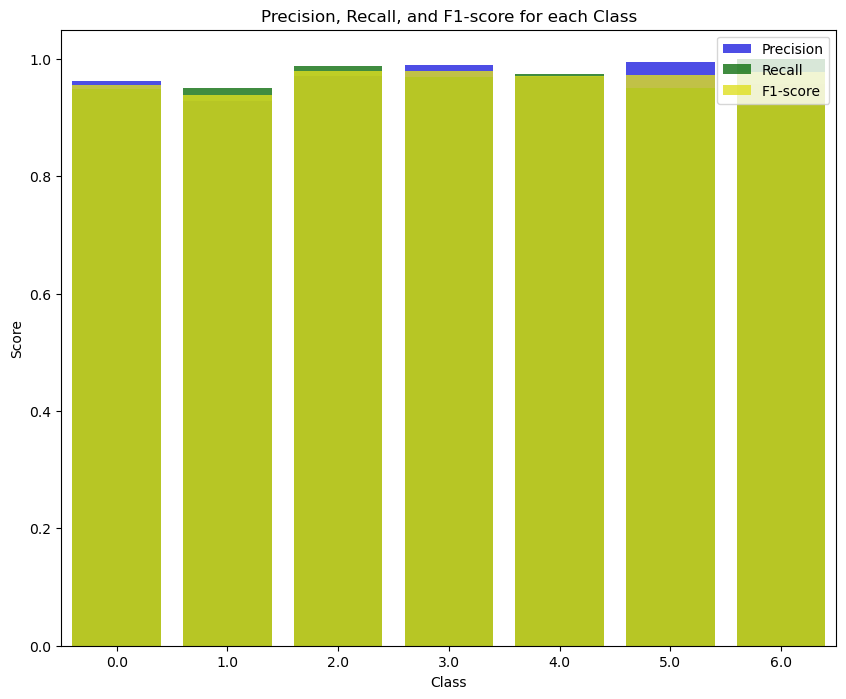

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       219
         1.0       0.93      0.95      0.94       180
         2.0       0.97      0.99      0.98       172
         3.0       0.99      0.97      0.98       200
         4.0       0.97      0.97      0.97       190
         5.0       0.99      0.95      0.97       203
         6.0       0.96      1.00      0.98       184

    accuracy                           0.97      1348
   macro avg       0.97      0.97      0.97      1348
weighted avg       0.97      0.97      0.97      1348



In [22]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
evaluate_model(model, all_data_shuffled_scaled, all_labels_shuffled)

Accuracy: 0.9695845697329377


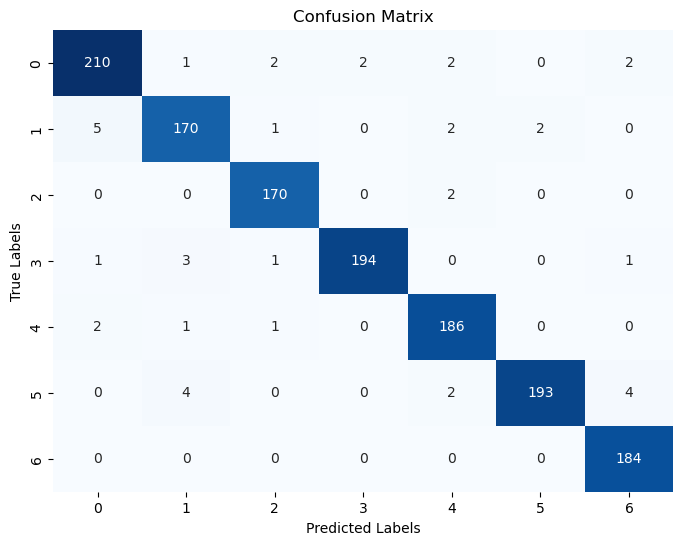

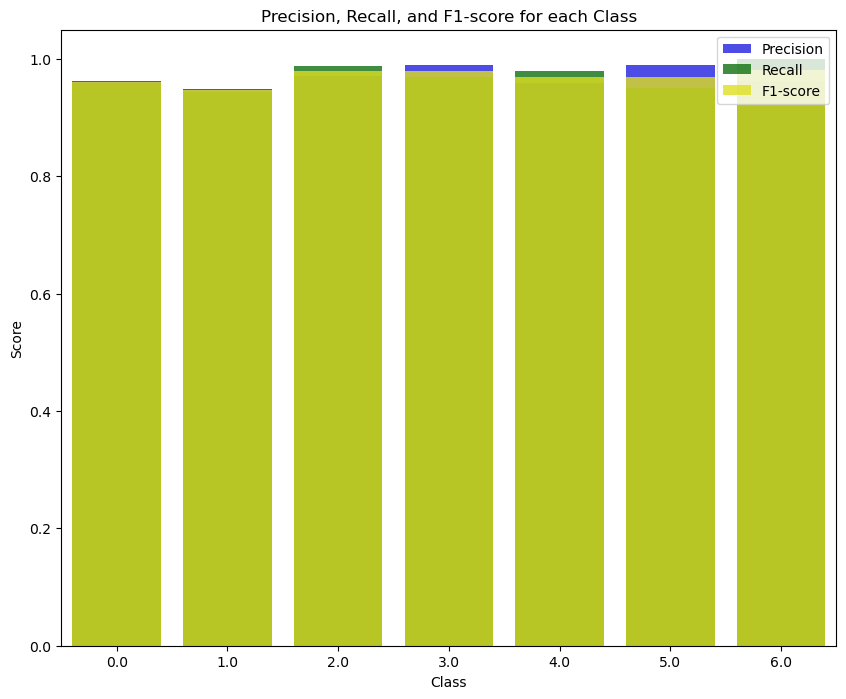

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       219
         1.0       0.95      0.94      0.95       180
         2.0       0.97      0.99      0.98       172
         3.0       0.99      0.97      0.98       200
         4.0       0.96      0.98      0.97       190
         5.0       0.99      0.95      0.97       203
         6.0       0.96      1.00      0.98       184

    accuracy                           0.97      1348
   macro avg       0.97      0.97      0.97      1348
weighted avg       0.97      0.97      0.97      1348



In [23]:
model = SVC(kernel="rbf")
evaluate_model(model, pca_tr, all_labels_shuffled)

#### Random Forest Model


Accuracy: 0.9629080118694362


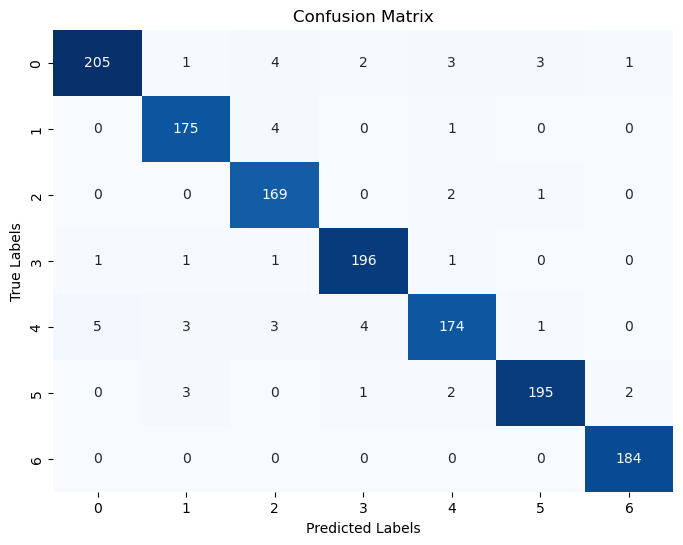

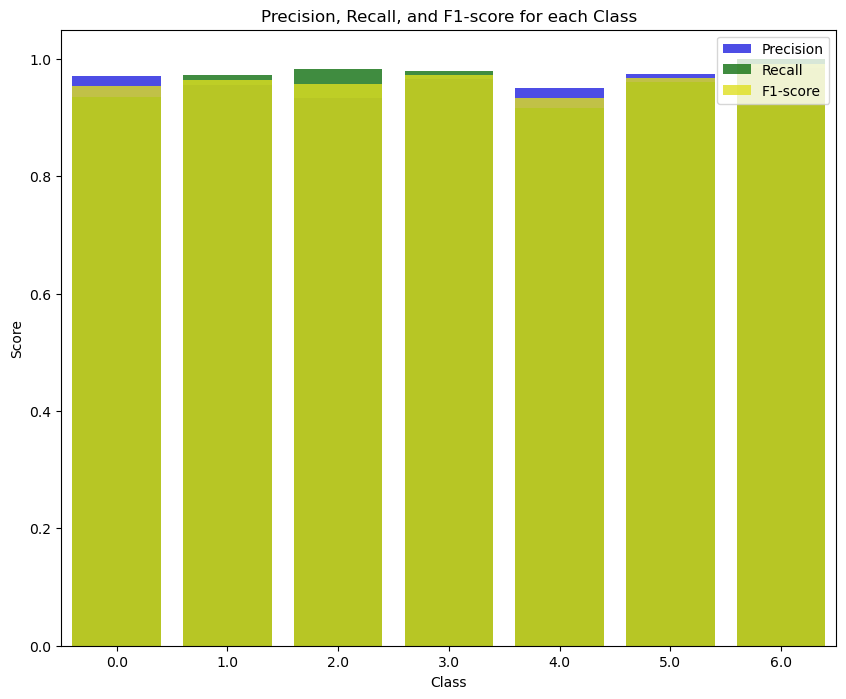

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       219
         1.0       0.96      0.97      0.96       180
         2.0       0.93      0.98      0.96       172
         3.0       0.97      0.98      0.97       200
         4.0       0.95      0.92      0.93       190
         5.0       0.97      0.96      0.97       203
         6.0       0.98      1.00      0.99       184

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

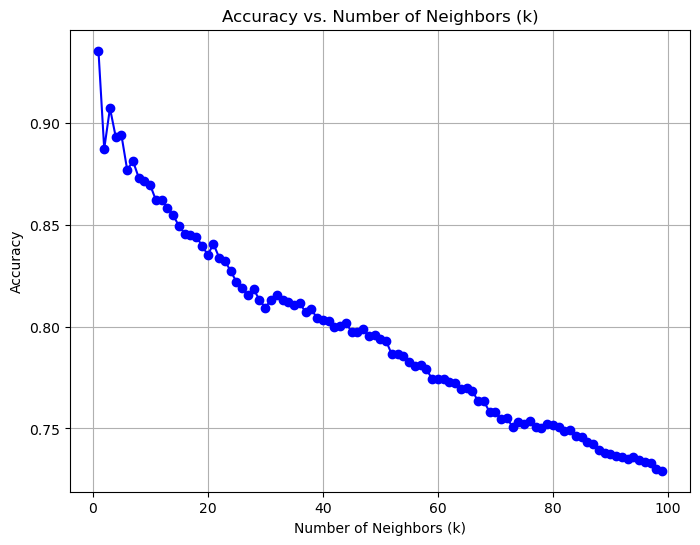

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tr, all_labels_shuffled, test_size=0.2, random_state=42)

# Initialize lists to store accuracy scores for different k values
k_values = list(range(1, 100))
accuracy_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


Accuracy: 0.8731454005934718


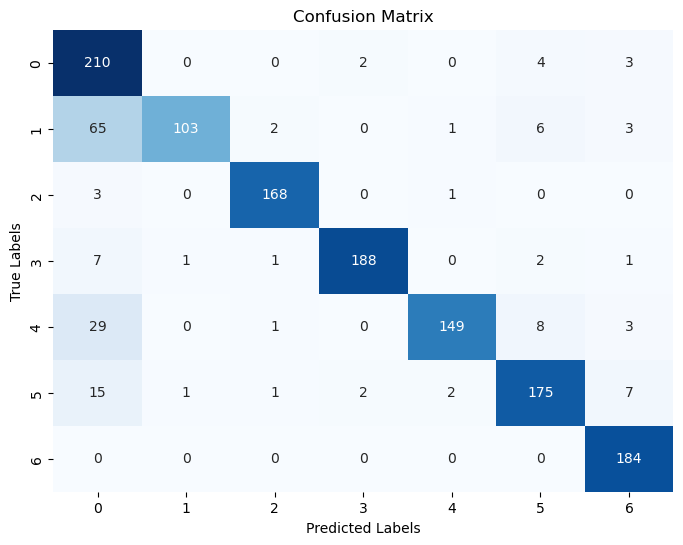

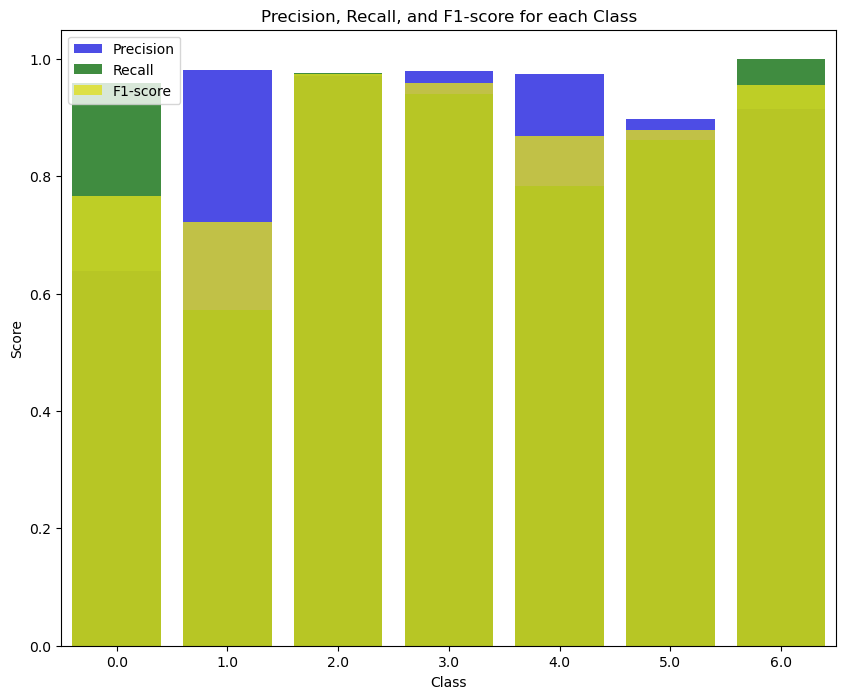

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.96      0.77       219
         1.0       0.98      0.57      0.72       180
         2.0       0.97      0.98      0.97       172
         3.0       0.98      0.94      0.96       200
         4.0       0.97      0.78      0.87       190
         5.0       0.90      0.86      0.88       203
         6.0       0.92      1.00      0.96       184

    accuracy                           0.87      1348
   macro avg       0.91      0.87      0.88      1348
weighted avg       0.90      0.87      0.87      1348



In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors = 8)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

Accuracy: 0.9428783382789317


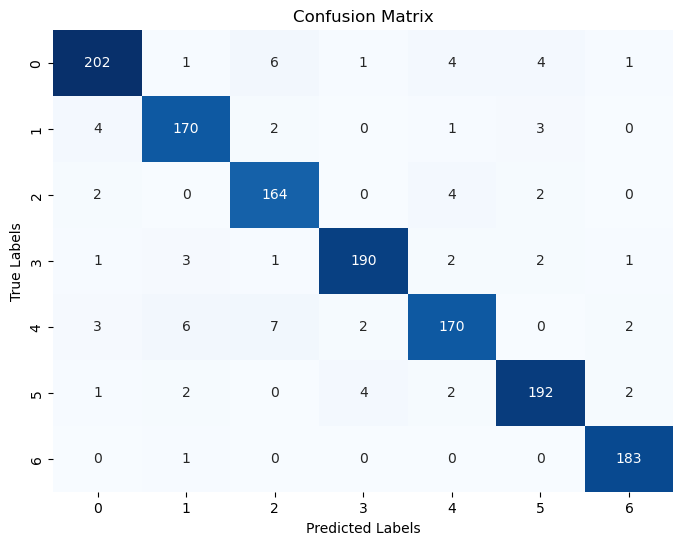

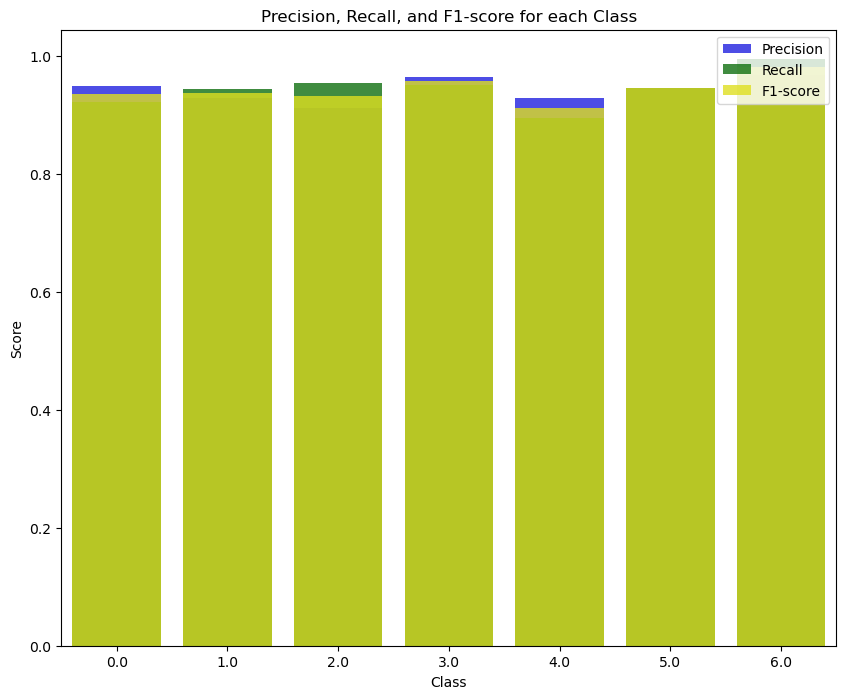

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       219
         1.0       0.93      0.94      0.94       180
         2.0       0.91      0.95      0.93       172
         3.0       0.96      0.95      0.96       200
         4.0       0.93      0.89      0.91       190
         5.0       0.95      0.95      0.95       203
         6.0       0.97      0.99      0.98       184

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



In [27]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,                # Number of classes in the multi-class problem
    'eval_metric': 'mlogloss',     # Multiclass Logarithmic Loss
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

xgb_model = xgb.XGBClassifier(**params)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)

In [30]:
test_Data,test_labels = load_data(subject_count=8)

Subject 8: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


In [38]:
subj78data={}
subj78data["7"] =  test_Data[6]
subj78data["8"] = test_Data[7]
subj78label = {}
subj78label["7"] =  test_labels[6]
subj78label["8"] = test_labels[7]